In [50]:
import numpy as np
import pandas as pd
import extinction
from astropy.io import fits
from astropy.table import Table
from helper import phys
from helper.specread import get_keck, gaplinelist
from helper.readfilter import get_UVOT_eff_wave
from helper.specread import add_telluric_circle, pblines
from helper.specread import truncate_spec, measure_flux, gaus
from helper.app2abs import add_physcol, deredden_df, app2abs_df
from allsn_info import get_at2019dge
from scipy.interpolate import splrep, splev, interp1d

import matplotlib
import matplotlib.pyplot as plt
fs= 14
matplotlib.rcParams['font.size']=fs

%matplotlib notebook

Updated SMA values: The actual rms in the images are 0.75 mJy for the 230 GHz image and 2.8 mJy for the 345 GHz image.

In [2]:
result = get_at2019dge()
z = result["z"]
ebv = result["ebv"]
ebv = result["ebv"]
t_max = result["t_max"]

In [3]:
dt6 = get_keck(z=z, date = "20190831_Keck1_v1", vkernel = 200, t0jd = t_max, ebv = ebv)

In [4]:
dt6["freq"] = phys.c / (dt6["wave_rest"]*1e-8)
dt6["fnu"] = dt6["wave_rest"] * dt6['spec_obs'] / dt6["freq"]

### Swift Photometry

In [5]:
lcuvot = pd.read_csv("../data/photometry/Swift/2019_06_23.csv") # 3 arcsec

In [6]:
wvU, xU, yU = get_UVOT_eff_wave("Swift_UVOT.U.dat", return_type = 'more')
wvB, xB, yB = get_UVOT_eff_wave("Swift_UVOT.B.dat", return_type = 'more')
wvV, xV, yV = get_UVOT_eff_wave("Swift_UVOT.V.dat", return_type = 'more')
wvUW1, xUVW1, yUVW1 = get_UVOT_eff_wave("Swift_UVOT.UVW1.dat", return_type = 'more')
wvUW2, xUVW2, yUVW2 = get_UVOT_eff_wave("Swift_UVOT.UVW2.dat", return_type = 'more')
wvUM2, xUVM2, yUVM2 = get_UVOT_eff_wave("Swift_UVOT.UVM2.dat", return_type = 'more')
#print (wvUW2, wvUM2, wvUW1, wvU, wvB, wvV)

lcuvot['wave'] = np.zeros(len(lcuvot))
lcuvot['wave'].values[lcuvot["filter"].values=="B"] = wvB
lcuvot['wave'].values[lcuvot["filter"].values=="U"] = wvU
lcuvot['wave'].values[lcuvot["filter"].values=="V"] = wvV
lcuvot['wave'].values[lcuvot["filter"].values=="UVM2"] = wvUM2
lcuvot['wave'].values[lcuvot["filter"].values=="UVW1"] = wvUW1
lcuvot['wave'].values[lcuvot["filter"].values=="UVW2"] = wvUW2
lcuvot["freq"] = phys.c / (lcuvot['wave'].values * 1e-8)

lcuvot = lcuvot.drop(columns = ["limmag", "filter"])
lcuvot["instrument"] = "Swift"

### WISE Photometry (Cutri+ 2012)
http://wise2.ipac.caltech.edu/docs/release/allsky/expsup/figures/sec4_4ht9.gif
- W1mag: 16.008 +- 0.043
- W2mag: 15.979	+- 0.102	

### SDSS DR12:
http://skyserver.sdss.org/dr1/en/proj/advanced/color/sdssfilters.asp
- umag: 19.336 +- 0.039	
- gmag: 18.322 +- 0.009	
- rmag: 17.913 +- 0.009	
- imag: 17.745 +- 0.010	
- zmag: 17.580 +- 0.031

### PS1
http://www.mso.anu.edu.au/~brad/filters.html
- gmag: 19.3497 +- 0.0297
- rmag: 19.1833	+- 0.0305
- imag: 19.0345	+- 0.0365
- zmag: 18.9435	+- 0.0360
- ymag: 18.7073	+- 0.0520

### legacysurveys_photoz_DR6
http://legacysurvey.org/dr8/description/
- gmag: 18.289905548095703 +- 0.002415424445644021
- rmag: 17.8510684967041 +- 0.0027493112720549107
- zmag: 17.57895851135254 +- 0.0045130071230232716
- w1mag: 18.293977737426758 +- 0.008171268738806248
- w2mag: 18.8624324798584 +- 0.029585016891360283

In [7]:
mags = [16.008, 15.979, 19.336, 18.322, 17.913, 17.745, 17.580, 19.3497, 19.1833, 19.0345, 18.9435, 18.7073,
        18.2899, 17.8511, 17.5790]
emags = [0.043, 0.102, 0.039, 0.009, 0.009, 0.010, 0.031, 0.0297, 0.0305, 0.0365,  0.0360, 0.0520,
        0.0024, 0.0027, 0.0045]
freqs = [8.8560e+13, 6.4451e+13, 
         phys.c/(3543e-8), phys.c/(4770e-8), phys.c/(6231e-8), phys.c/(7625e-8), phys.c/(9134e-8),
         phys.c/(5460e-8), phys.c/(6800e-8), phys.c/(7450e-8), phys.c/(8700e-8), phys.c/(9780e-8),
         phys.c/(4770e-8), phys.c/(6231e-8), phys.c/(9134e-8)]
mjds = np.ones(len(mags))*58580
instruments = ["WISE", "WISE", "SDSS", "SDSS", "SDSS", "SDSS", "SDSS", "PS1", "PS1","PS1","PS1","PS1",
              "DEC", "DEC", "DEC"]
d = {'mag': mags, 'emag': emags, "freq": freqs, "mjd": mjds, "instrument": instruments}
df = pd.DataFrame(data=d)
df["wave"] = phys.c / df['freq'].values * 1e8 # Hz

In [8]:
lcuvot = pd.concat([lcuvot, df],sort=True)

In [9]:
#lcuvot = lcuvot[lcuvot.instrument!="Swift"]
#lcuvot = lcuvot[lcuvot.instrument!="PS1"]

In [10]:
lcuvot = deredden_df(lcuvot, ebv = ebv)
lcuvot = app2abs_df(lcuvot, z=z, t_max = t_max)
lcuvot = add_physcol(lcuvot, magcol = "mag")

In [11]:
lcuvot.head()

,emag,freq,instrument,mag,mjd,wave,mag0,tmax_rf,tmax_of,mag0_abs,fratio,fratio_unc,fnu,fnu_unc,nufnu,nufnu_unc,flambda,flambda_unc,Llambda,Llambda_unc
0,0.16,6.877463e+14,Swift,18.55,58657.804769,4359.055837,18.458641,73.048828,74.604769,-16.378025,3.801894e-08,5.602678e-09,1.380468e-27,2.034332e-28,9.494116e-13,1.399105e-13,2.178021e-16,3.209651e-17,2.605992e+24,3.840331e+23
1,0.13,8.625893e+14,Swift,21.02,58657.803356,3475.494702,20.911024,73.047446,74.603356,-13.925642,3.908409e-09,4.679711e-10,1.419143e-28,1.699203e-29,1.224138e-13,1.465714e-14,3.522197e-17,4.217283e-18,4.214292e+23,5.045959e+22
2,0.19,1.329411e+15,Swift,21.09,58657.813056,2255.077725,20.884704,73.056943,74.613056,-13.951962,3.664376e-09,6.412528e-10,1.330535e-28,2.328389e-29,1.768827e-13,3.095385e-14,7.843753e-17,1.372629e-17,9.385013e+23,1.642344e+23
3,0.12,1.146775e+15,Swift,19.12,58657.800602,2614.221271,18.974418,73.044749,74.600602,-15.862248,2.249055e-08,2.485747e-09,8.166317e-28,9.025747e-29,9.364932e-13,1.035050e-13,3.582303e-16,3.959307e-17,4.286208e+24,4.737292e+23
4,0.16,1.441980e+15,Swift,20.65,58657.806181,2079.033684,20.439991,73.050211,74.606181,-14.396676,5.495409e-09,8.098334e-10,1.995383e-28,2.940505e-29,2.877302e-13,4.240149e-14,1.383961e-16,2.039481e-17,1.655903e+24,2.440229e+23


Let us calibrate the host spectrum with SDSS $r$ band photometry

In [12]:
tb = Table(fits.open("../data/filters/SDSS/filter_curves.fits")[3].data)
wv_sdssr = tb["wavelength"].data
fl_sdssr = tb["respt"].data

xx = dt6["wave_rest"]
yy = dt6["spec_obs0"]
ind = (xx>wv_sdssr[0])&(xx<wv_sdssr[-1])
xx = xx[ind]
yy = yy[ind]
xx_diff_ = xx[1:] - xx[:-1]
xx_diff = 0.5 * (np.hstack([xx_diff_[0], xx_diff_]) + np.hstack([xx_diff_, xx_diff_[-1]]))

In [13]:
func_response = interp1d(wv_sdssr, fl_sdssr)
y_response = func_response(xx)

flux_original = np.sum(xx_diff * y_response * yy) / np.sum(xx_diff * y_response)

flux_sdss = lcuvot["flambda"].values[(lcuvot["instrument"].values=="SDSS")&(lcuvot["mag"].values==17.913)]

factor = flux_sdss[0] / flux_original
print (factor)

2.306892360491907


In [14]:
yaolist = gaplinelist(z=0)
H_list = yaolist['H_list']
OIII_list = yaolist['OIII_list']
NII_list = yaolist['NII_list']

## 1. Host extinction estimate by Balmer decrement
### 1.1 fit the continuum, excluding major nebula lines

In [15]:
knots = np.hstack([np.linspace(3700, 4700, 6), np.linspace(5000, 9500, 3)])

Regions marked in red are removed from continuum fitting

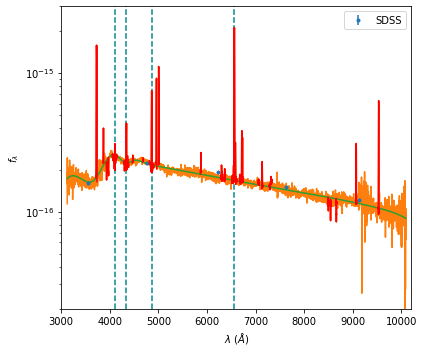

In [16]:
plt.figure(figsize=(6,5))
axi = plt.subplot(111)
inst = "SDSS"
ix = lcuvot["instrument"].values == inst
axi.errorbar(lcuvot["wave"].values[ix], lcuvot["flambda"].values[ix], lcuvot["flambda_unc"].values[ix], fmt=".", label = inst)
axi.plot(dt6["wave_rest"], dt6["spec_obs0"]*factor)
plt.plot(2.3e+11, 750,  "o", marker='v',color='k')
plt.plot(3.45e+11, 2800, "o", marker='v',color='k')
plt.legend()
plt.semilogy()
#plt.semilogx()
axi.set_xlabel(r"$\lambda$"+" ($\AA$)")
plt.xlim(3000, 10200)
axi.set_ylabel(r"$f_\lambda$")
wv_cont_, fl_cont_ = truncate_spec(dt6["wave_rest"], dt6["spec_obs0"]*factor, axi)
t,c,k = splrep(wv_cont_, fl_cont_, k=3, task=-1, t = knots)
flux_cont = splev(dt6["wave_rest"], (t,c,k)) 

plt.plot(dt6["wave_rest"], flux_cont)

tbottom = 2e-17
tup = 3e-15
plt.ylim(tbottom, tup)
pblines(axi, H_list, color='darkcyan', label="He I", tb = tbottom, tu = tup, ls = '--')
plt.tight_layout()

In [17]:
flux_line = dt6["spec_obs0"]*factor - flux_cont

### 1.2 measure H$\beta$ and H$\alpha$ line flux

- H$\alpha$ is straightforward since there is no obvious absorption lines and we can simply fit a Gaussian
- H$\beta$ is harder since the absorption system from stellar population is pretty strong

Line flux uncertianty are measured by generating new Gaussian parameters from the covariance matrix (Cholesky decomposition).

#### H$\alpha$

line width = 2.42 AA
line center is 6562.07 +- 0.03


<IPython.core.display.Javascript object>


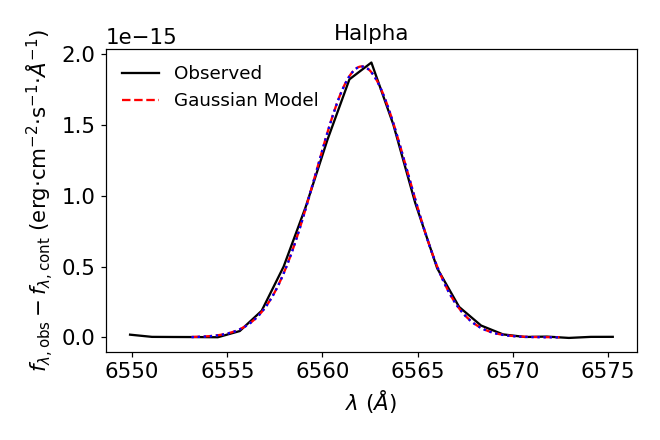

line flux of Halpha is: 115.79 +- 1.65 1e-16


In [65]:
flux_Halpha = measure_flux(dt6["wave_rest"], flux_line, line_center = H_list[-1],  sigma_guess = 2.5,
                           line_left = 13, line_right = 13, 
                           line_bound_width = 1., linename = "Halpha")

#### H$\beta$
- remove the emission line and model the board absorption profile
- model the emission line profile

In [19]:
ind = np.any([dt6["wave_rest"]<4854.7, dt6["wave_rest"]>4871.8], axis=0)
wave_tmp = dt6["wave_rest"][ind]
flux_tmp = flux_line[ind]

In [20]:
wave_tmp

array([ 3125.14275923,  3127.08547929,  3129.02868893, ...,
       10085.64476647, 10086.80798982, 10087.97121316])

line width = 11.98 AA
line center is 4862.35 +- 1.88
line flux of Hbeta is: -8.39 +- 1.21 1e-16


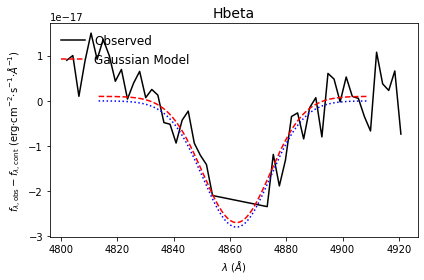

In [24]:
flux_Hbeta = measure_flux(wave_tmp, flux_tmp, line_center = H_list[-2],  sigma_guess = 15,
                              line_bound_width = 1., linename = "Hbeta", line_left = 60, line_right = 60,
                              emission_flag = 0)

In [27]:
flux_abs = gaus(dt6["wave_rest"], *flux_Hbeta["popt"])*1e-16

<IPython.core.display.Javascript object>


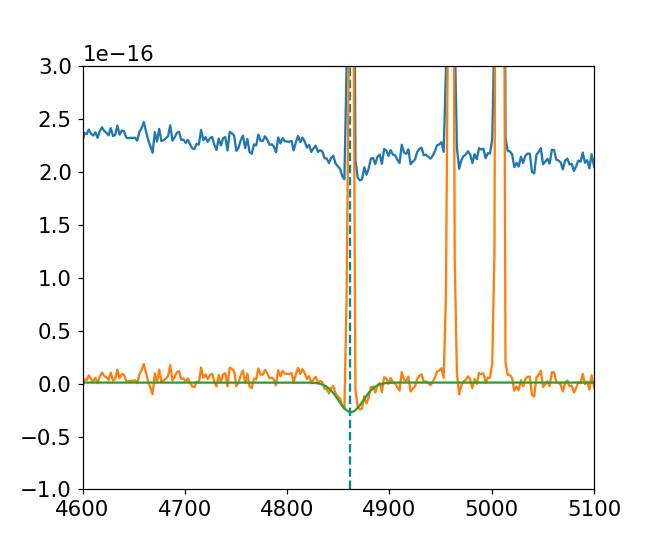

In [54]:
plt.figure(figsize=(6,5))
axi = plt.subplot(111)
axi.plot(dt6["wave_rest"], dt6["spec_obs0"]*factor)
axi.plot(dt6["wave_rest"], flux_line)
axi.plot(dt6["wave_rest"], flux_abs)
tbottom = -1e-16
tup = 3e-16
plt.ylim(tbottom, tup)
plt.xlim(4600, 5100)
pblines(axi, H_list, color='darkcyan', label="He I", tb = tbottom, tu = tup, ls = '--')

In [55]:
flux_line_  = flux_line - flux_abs

In [30]:
dt6["wave_rest"].shape

(5050,)

line width = 2.26 AA
line center is 4862.35 +- 0.13


<IPython.core.display.Javascript object>


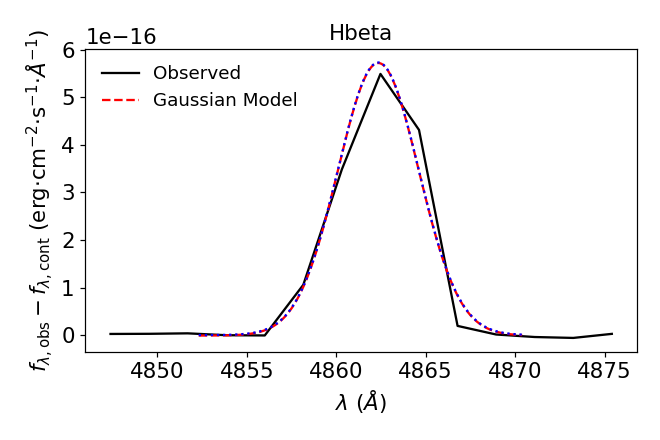

line flux of Hbeta is: 32.45 +- 2.18 1e-16


In [64]:
flux_Hbeta = measure_flux(dt6["wave_rest"], flux_line_, line_center = H_list[-2],  sigma_guess = 2.5,
                              line_bound_width = 1., linename = "Hbeta",
                              line_left = 15, line_right = 15)

Some other lines

line width = 3.06 AA
line center is 5007.06 +- 0.60


<IPython.core.display.Javascript object>


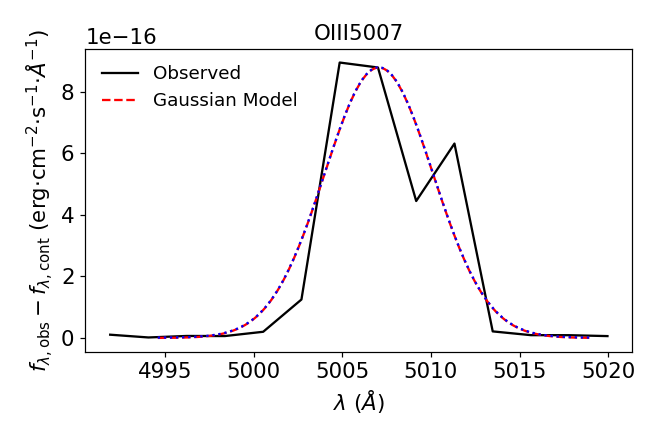

line flux of OIII5007 is: 67.56 +- 14.34 1e-16


In [57]:
flux_5007 = measure_flux(dt6["wave_rest"], flux_line, line_center = OIII_list[-1],  sigma_guess = 3,
                              line_bound_width = 1., linename = "OIII5007",
                              line_left = 15, line_right = 15)

In [112]:
OIII_list

array([4958.91, 5006.84])

In [ ]:
flux_4363 = measure_flux(dt6["wave_rest"], flux_line, line_center = OIII_list[-1],  sigma_guess = 3,
                              line_bound_width = 1., linename = "OIII5007",
                              line_left = 15, line_right = 15)

line width = 2.41 AA
line center is 6582.62 +- 0.10
line flux of NII6583 is: 8.89 +- 0.35 1e-16


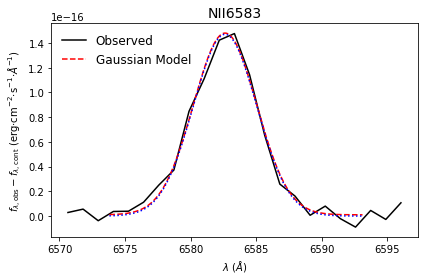

In [34]:
flux_6583 = measure_flux(dt6["wave_rest"], flux_line, line_center = NII_list[-1],  sigma_guess = 2.4,
                              line_bound_width = 1., linename = "NII6583",
                              line_left = 13, line_right = 13)

In [66]:
flux_Halpha["flux"]/flux_Hbeta["flux"]

3.5681929196245323

### 1.3 Convert line ratio to extinction (assume Case B recombination)
From Osterbrock & Ferland, Table 4.4. Let us use the value at $T=10000\,{\rm K}$ and $n_e = 100\,{\rm cm^{-3}}$. Then the line ratio should be 2.863.

Therefore, we have
\begin{equation}
2.863 \times {\rm exp}(-(\tau_{\rm H\alpha}-\tau_{\rm H\beta})) = 3.538 \\
2.863 \times {\rm exp}(-(A_{\rm H\alpha}-A_{\rm H\beta})/1.086) = 3.538 \\
(A_{\rm H\beta}-A_{\rm H\alpha}) = {\rm ln}(3.538/2.863)\times 1.086 \\
\end{equation}

In [88]:
lineratio = flux_Halpha["flux"]/flux_Hbeta["flux"]
lineratio_unc =  np.sqrt(flux_Hbeta["flux"]**2 * flux_Halpha["flux_unc"]**2+flux_Hbeta["flux_unc"]**2 * flux_Halpha["flux"]**2)/ (flux_Hbeta["flux"]**2)




In [91]:
lineratio_unc

0.24551759399426126

In [92]:
Adiff = np.log(lineratio / 2.863)*1.086
Adiff_unc = lineratio_unc / lineratio *1.086

As_at1 = extinction.ccm89(H_list[-2:], 1, 3.1) 
As_diff_at1 = As_at1[-2] - As_at1[-1]

AV_host = Adiff / As_diff_at1
AV_host_unc = Adiff_unc / As_diff_at1

ebv_host = AV_host / 3.1
ebv_host_unc = AV_host_unc / 3.1

In [95]:
ebv_host

0.22269741360748715

In [94]:
ebv_host_unc

0.06959104218523948

### 1.4 Deredden the host spectrum

In [69]:
Aextmag =  extinction.ccm89(dt6['wave_rest'], AV_host, 3.1)
tau =  Aextmag / 1.086
dt6["spec_obs00"] = dt6["spec_obs0"]*factor * np.exp(tau)

## 2. Metallicity Indicators

Following Marino et al. (2013), the Oxygen abundance in the N2 scale is
\begin{equation}
12 + {\rm log(O/H)} = 8.743[\pm0.027] + 0.462[\pm 0.024]\times {\rm N2}
\end{equation}

In [96]:
N2 = np.log10(flux_6583["flux"] / flux_Halpha["flux"])
N2_unc = np.sqrt(flux_6583["flux_unc"]**2/flux_6583["flux"]**2+flux_Halpha["flux_unc"]**2/flux_Halpha["flux"]**2)/np.log(10)



In [99]:
# statistical uncertainty
N2_unc * 0.462

0.00841710741003744

In [100]:
# systematic uncertainty
0.027 + 0.024*abs(N2)

0.053758734605204625

In [101]:
# O abundance 
8.743 + 0.462 * N2

8.227894358849811

## 3. Star Formation rate
Use Kennicutt et al. (1992), Eq (2):
    \begin{equation}
    {\rm SFR}(M_\odot\,{\rm yr^{-1}}) = 0.63\times \frac{L({\rm H}\alpha)}{1.26 \times 10^{41}\,{\rm erg\,s^{-1}}}.
    \end{equation}
The factor of 0.63 is added from Madau & Dickinson (https://arxiv.org/abs/1403.0007) to convert the Salpeter to a Chabrier IMF.

In [102]:
from astropy.cosmology import FlatLambdaCDM
import astropy.constants as const
cosmo = FlatLambdaCDM(H0=70., Om0=0.275)
D = cosmo.luminosity_distance([0.0213])[0].value * 1e+6 # in pc

In [104]:
tau_Halpha =  extinction.ccm89(H_list, AV_host, 3.1)[-1] / 1.086
tau_Halpha_unc =  extinction.ccm89(H_list, AV_host_unc, 3.1)[-1] / 1.086

In [105]:
pre_factor = 0.63 * 4*np.pi*(const.pc.cgs.value * D)**2/ 1.26e+41

In [109]:
SFR = pre_factor * flux_Halpha["flux"] *np.exp(tau_Halpha) 
SFR_unc = SFR * np.sqrt((flux_Halpha["flux_unc"]/flux_Halpha["flux"])**2+ tau_Halpha_unc**2)

In [110]:
SFR

0.10022497345352628

In [111]:
SFR_unc

0.016344144479501006

## 4. Electron Temperature and number density

I choose to use the measured [O III] 4363 / [O III] 5007 as a temperature diagnostics. We can show (Draine Chap 18) that in the low density limit ($n_e \ll n_{\rm crit}$), this ratio:
\begin{equation}
    \frac{{^1}S_{0} - {^1}D_{2}}{{^1}D_{2} - {^3}P_{2}} = \frac{1.34}{9.03\times {\rm exp}\left( \frac{3.3\times 10^4}{{\rm T (K)}} \right) \times  +1} \times \frac{5006.84}{4363.21}
\end{equation}
only depends on temperature. 

In order to calculate this more accurately let us use the `pyneb` package.

-1.1149472752168594

In [ ]:
insts = np.unique(lcuvot["instrument"].values)

plt.figure(figsize=(6,5))
axi = plt.subplot(111)
for inst in insts:
    ix = lcuvot["instrument"].values == inst
    axi.errorbar(lcuvot["freq"].values[ix], lcuvot["fnu"].values[ix]*1e29, lcuvot["fnu_unc"].values[ix]*1e29, fmt=".", label = inst)
axi.plot(dt6["freq"], dt6["fnu"]*1e29)
plt.plot(2.3e+11, 750,  "o", marker='v',color='k')
plt.plot(3.45e+11, 2800, "o", marker='v',color='k')
plt.legend()
#plt.xlim(1e+11, 2e+11)
plt.semilogy()
plt.semilogx()
axi.set_xlabel(r"$\nu$"+" (Hz)")
axi.set_ylabel(r"$\mu$"+"Jy")
plt.tight_layout()

In [ ]:
from ztfquery import query

zquery = query.ZTFQuery()
zquery.load_metadata(kind="ref",radec=[2.641947887000000037e+02, +5.054782600000000059e+01], size=0.0001)

zquery.metatable[["field","filtercode", "ccdid","qid"]]

zquery.download_data()